<h1 style="text-align:center;">Projet Lichess</h1>
<center>Rafik KEDACHE et Zoé PURSON-PASQUALINI</center>

Ce projet a été réalisé sur Colab, il est également accessible à ce <a href="https://colab.research.google.com/drive/13DYAGh-10mL7z_jlqMWrcNmlLaRMPQzi?usp=sharing">lien</a>.

## Setup préalable de Spark et de Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SPARK_VER = "3.5.7"
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-$SPARK_VER/spark-$SPARK_VER-bin-hadoop3.tgz
!tar xf spark-$SPARK_VER-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-" + SPARK_VER + "-bin-hadoop3"  # this is proper to Colab
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,411 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,860 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,598 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [69.2 kB]
Ge

## Analyse préalable du jeu de données.

Commençons par charger nos données. Puis faire quelques petites analyses préalables.

In [ ]:
!curl -L -o /content/lichess-september-2020-data.zip \
  https://www.kaggle.com/api/v1/datasets/download/noobiedatascientist/lichess-september-2020-data
!unzip /content/lichess-september-2020-data.zip -d /content/lichess_data

sc = spark.sparkContext
data_dir = "/content/lichess_data"
data_file = data_dir + "/Sept_20_analysis.csv"

data = sc.textFile(data_file)
lichess_df = spark.read.csv(data, header=True, inferSchema=True, encoding="latin1")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  324M  100  324M    0     0  97.5M      0  0:00:03  0:00:03 --:--:--  107M
Archive:  /content/lichess-september-2020-data.zip
  inflating: /content/lichess_data/Column information.txt  
  inflating: /content/lichess_data/Sept_20_analysis.RDS  
  inflating: /content/lichess_data/Sept_20_analysis.csv  


In [ ]:
lichess_df.show()

+----+--------+---------------+----------+---+--------------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|               Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_move

In [ ]:
# Analyse de la distribution par type de parties dans le jeu de données
from pyspark.sql.functions import col
# Ajout d'un filtre par type de partie
nb_parties_blitz = lichess_df.filter(col("Event").contains("Blitz")).count()
nb_parties_classique = lichess_df.filter(col("Event").contains("Classical")).count()
nb_parties_rapid = lichess_df.filter(col("Event").contains("Rapid")).count()
nb_parties_bullet = lichess_df.filter(col("Event").contains("Bullet")).count()
nb_parties_correspondance = lichess_df.filter(col("Event").contains("Correspondence")).count()

print(f"""Il y a {nb_parties_blitz} parties Blitz, {nb_parties_classique} parties Classiques, {nb_parties_rapid} parties Rapides,
{nb_parties_bullet} parties Bullet et UltraBullet et {nb_parties_correspondance} parties par correspondances sur les {lichess_df.count()} parties totales""")

# Vérification qu'aucune partie n'a été laissée de côté
check_somme = nb_parties_blitz+nb_parties_classique+nb_parties_rapid+nb_parties_bullet+nb_parties_correspondance
print ("Somme valides" if check_somme == lichess_df.count() else "Somme invalide, tous les types de parties n'ont pas été prises en compte")

Il y a 1746265 parties Blitz, 149128 parties Classiques, 1039702 parties Rapides, /
794470 parties Bullet et UltraBullet et 10344 parties par correspondances sur les 3739909 parties totales
Somme valides


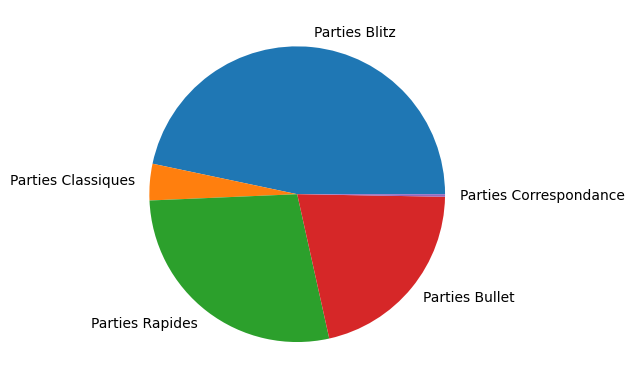

In [ ]:
import matplotlib.pyplot as plt

# Visualisation de la distribution par type de parties
labels = 'Parties Blitz', 'Parties Classiques', 'Parties Rapides', 'Parties Bullet', 'Parties Correspondance'
sizes = [nb_parties_blitz, nb_parties_classique, nb_parties_rapid, nb_parties_bullet, nb_parties_correspondance]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels);

On peut remarquer un certain deséquilibre dans la distribution de nos données. Il existe bien plus de parties *Blitz*, *Bullet* et *Rapid* que de parties *classiques* ou par *correspondance*.

Regardons les résultats obtenus, pour le moment de manière générale puis par type de parties.

Pour rappel : <br><b>1-0</b> : Victoire des blancs ;<br> <b>0-1</b> : Victoire des noirs ;<br><b>1/2-1/2</b> : Egalité ; <br><b>*</b> : Non décidé

In [ ]:
victoires_bl = lichess_df.where(col("Result") == "1-0") # Victoire des blancs
victoires_no = lichess_df.where(col("Result") == "0-1") # Victoire des noirs
egalite = lichess_df.where(col("Result") == "1/2-1/2") # Egalité
indef = lichess_df.where(col("Result") == "*") # Indéfini
print(f"""Il y a {victoires_bl.count()} victoires des blancs,
{victoires_no.count()} victoires des noirs, {egalite.count()} égalités
et {indef.count()} parties où le résultat était indéfini.""")

Il y a 1863894 victoires des blancs, 
1766395 victoires des noirs, 109548 égalités 
et 72 parties où le résultat était indéfini.


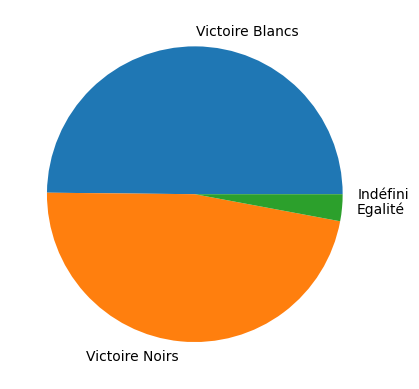

In [ ]:
labels = 'Victoire Blancs', 'Victoire Noirs', 'Egalité', 'Indéfini'
sizes = [victoires_bl.count(), victoires_no.count(), egalite.count(), indef.count()]

fig, ax = plt.subplots()
# Ajout du point virgule pour ne pas avoir un surplus d'informations
ax.pie(sizes, labels=labels);

On peut observer que la distribution entre la victoire des noirs et celle des blancs est presque la même. Qu'il y a peu d'égalité et une infime partie de résultats indéfinis (72/3 739 909).

Maintenant, concentrons nous sur la part des parties où l'issue était égalité.

In [ ]:
import pandas as pd
# Tous les types de parties
types_parties = {
    "Classical": "classiques",
    "Blitz": "blitz",
    "Bullet": "bullet",
    "Correspondence": "correspondance",
    "Rapid": "rapides"
}

stats_parties = []

for event, label in types_parties.items():
    stats = (
        lichess_df
        .filter(col("Event").contains(event))
        .groupBy("Result")
        .count()
        .collect()
    )

    counts = {row["Result"]: row["count"] for row in stats}
    total = sum(counts.values())

    stats_parties.append({
        "type_partie": label,
        "event": event,
        "victoires_blancs": counts.get("1-0", 0),
        "victoires_noirs": counts.get("0-1", 0),
        "egalites": counts.get("1/2-1/2", 0),
        "indefinis": counts.get("*", 0),
        "proportion_egalites": (counts.get("1/2-1/2", 0) / total) * 100 if total > 0 else 0
    })


df_stats_parties = pd.DataFrame(stats_parties)


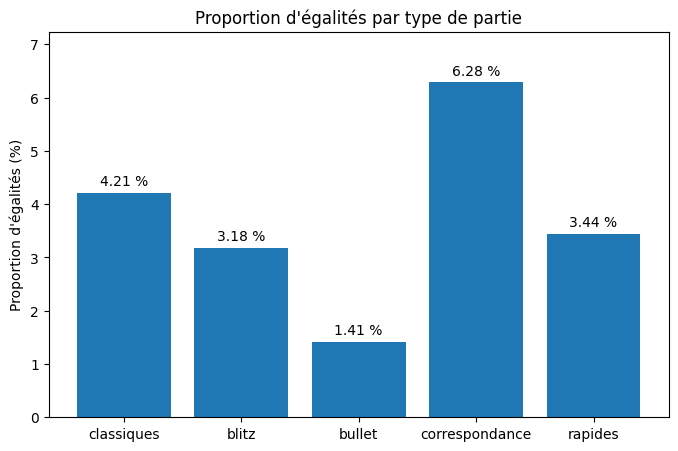

In [ ]:
# Diagramme pour représenter la proportion d'égalité par type de parties
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(
    df_stats_parties["type_partie"],
    df_stats_parties["proportion_egalites"]
)

ax.bar_label(
    bars,
    # Pour plus de simplicité de lecture, nous avons rajouté le pourcentage
    labels=[f"{val:.2f} %" for val in df_stats_parties["proportion_egalites"]],
    padding=3
)

ax.set_ylabel("Proportion d'égalités (%)")
ax.set_title("Proportion d'égalités par type de partie")
ax.set_ylim(0, df_stats_parties["proportion_egalites"].max() * 1.15)

plt.show();


On observe que les parties de type *Bullet* sont celles pour lesquelles la proportion de parties se terminant par une égalité est la plus faible, avec seulement 1,41% de matchs nuls.

## Question 1 - Taux de bourdes, d'erreur et d'imprécision par coup, selon les catégories de niveaux sur les parties de type *Blitz*

Pour cette question, nous allons faire en sorte de calculer les bourdes, les erreurs ainsi que les imprécisions par coup selon les catégories dans les parties en mode *Blitz*. Pour cela, nous allons d'abord faire en sorte de filtrer les parties *Blitz* dont les joueurs ont la même catégorie d'ELO. Par la suite, nous allons les grouper en fonction des différents niveaux et faire la somme respective des bourdes, erreurs et imprécisions. Puis, par la suite, on va diviser chacune de ces sommes par le nombre total de coups joués pour pouvoir avoir le taux.

Les formules utilisées sont :

$$\text{Taux Bourdes} = \frac{\sum (\text{Bourdes Blancs} + \text{Bourdes Noirs})}{\sum \text{Total des coups}}$$

$$\text{Taux Erreurs} = \frac{\sum (\text{Erreurs Blancs} + \text{Erreurs Noirs})}{\sum \text{Total des coups}}$$

$$\text{Taux Imprécisions} = \frac{\sum (\text{Imprécisions Blancs} + \text{Imprécisions Noirs})}{\sum \text{Total des coups}}$$



**Colonnes utilisées pour cette analyse :**

**Filtres :**
*   `Event` (pour identifier le type *Blitz*).
*   `White_elo_category` `Black_elo_category`.

**Données d'analyse :**
*   `White_blunders`, `Black_blunders`.
*   `White_mistakes`, `Black_mistakes`.
*   `White_inaccuracies`, `Black_inaccuracies`.
*   `Total_moves`.


**Version en ne considérant que les parties dont les deux joueurs sont dans la même catégorie**

In [ ]:
from pyspark.sql import functions as f

# On définit les 5 catégories pour le joueur BLANC
lichess_df = lichess_df.withColumn("White_Level",
    f.when(lichess_df['WhiteElo'] < 1500, "joueur occasionnel (<1500)")
     .when(lichess_df['WhiteElo'] < 1800, "bon joueur de club (1500-1799)")
     .when(lichess_df['WhiteElo'] < 2000, "très bon joueur de club (1800-1999)")
     .when(lichess_df['WhiteElo'] < 2400, "niveau national et international (2000-2399)")
     .otherwise("GMI, Champions du monde (>2400)")
)

# On fait la même chose pour le joueur NOIR (basé sur BlackElo)
lichess_df = lichess_df.withColumn("Black_Level",
    f.when(lichess_df['BlackElo'] < 1500, "joueur occasionnel (<1500)")
     .when(lichess_df['BlackElo'] < 1800, "bon joueur de club (1500-1799)")
     .when(lichess_df['BlackElo'] < 2000, "très bon joueur de club (1800-1999)")
     .when(lichess_df['BlackElo'] < 2400, "niveau national et international (2000-2399)")
     .otherwise("GMI, Champions du monde (>2400)")
)

# Filtrage avec Blitz et Les deux joueurs ont la même catégorie
blitz_df = lichess_df.filter(lichess_df['Event'].contains("Blitz") & (lichess_df['White_Level'] == lichess_df['Black_Level']))

# GroupBy sur la nouvelle catégorie
stats_df = blitz_df.groupBy('White_Level').agg(
    f.sum(blitz_df['Black_blunders'] + blitz_df['White_blunders']).alias('total_blunders'),
    f.sum(blitz_df['Black_mistakes'] + blitz_df['White_mistakes']).alias('total_mistakes'),
    f.sum(blitz_df['Black_inaccuracies'] + blitz_df['White_inaccuracies']).alias('total_imprecisions'),
    f.sum(blitz_df['Total_moves']).alias('total_moves')
)

# Calcul des taux et affichage
results_df = stats_df.withColumn("Blunder_Rate", stats_df['total_blunders'] / stats_df['total_moves']) \
                      .withColumn("Mistake_Rate", stats_df['total_mistakes'] / stats_df['total_moves']) \
                      .withColumn("Inaccuracy_Rate", stats_df['total_imprecisions'] / stats_df['total_moves']) \
                      .orderBy("White_Level")

results_df.show(truncate=False)

+--------------------------------------------+--------------+--------------+------------------+-----------+--------------------+-------------------+-------------------+
|White_Level                                 |total_blunders|total_mistakes|total_imprecisions|total_moves|Blunder_Rate        |Mistake_Rate       |Inaccuracy_Rate    |
+--------------------------------------------+--------------+--------------+------------------+-----------+--------------------+-------------------+-------------------+
|GMI, Champions du monde (>2400)             |38193         |78763         |87063             |1215578    |0.03141962095398239 |0.06479469026257467|0.07162271775237788|
|bon joueur de club (1500-1799)              |1619370       |2674973       |2472928           |27167223   |0.05960749098279202 |0.09846324742135035|0.09102616045813737|
|joueur occasionnel (<1500)                  |3029437       |3883296       |3349531           |37147009   |0.08155264936673637 |0.10453859151890264|0.09016

**Version en considérant l'ELO moyen des deux joueurs**

In [ ]:
from pyspark.sql import functions as f

# Filtrer pour garder seulement les Blitz
blitz_df = lichess_df.filter(lichess_df['Event'].contains("Blitz"))

# Calculer l'ELO moyen et créer la catégorie
blitz_df = blitz_df.withColumn("AvgElo", (blitz_df['WhiteElo'] + blitz_df['BlackElo']) / 2)

# On définit les tranches de niveaux
blitz_df = blitz_df.withColumn("Level_Category",
    f.when(blitz_df['AvgElo'] < 1500, "joueur occasionnel (<1500)")
     .when(blitz_df['AvgElo'] < 1800, "bon joueur de club (1500-1799)")
     .when(blitz_df['AvgElo'] < 2000, "très bon joueur de club (1800-1999)")
     .when(blitz_df['AvgElo'] < 2400, "niveau national et international (2000-2399)")
     .otherwise("GMI, Champions du monde (>2400)")
)

# Grouper par cette nouvelle catégorie et faire les sommes
stats_df = blitz_df.groupBy('Level_Category').agg(
    f.sum(blitz_df['Black_blunders'] + blitz_df['White_blunders']).alias('total_blunders'),
    f.sum(blitz_df['Black_mistakes'] + blitz_df['White_mistakes']).alias('total_mistakes'),
    f.sum(blitz_df['Black_inaccuracies'] + blitz_df['White_inaccuracies']).alias('total_imprecisions'),
    f.sum(blitz_df['Total_moves']).alias('total_moves')
)

# Calculer les taux
results_df = stats_df.withColumn("Blunder_Rate", stats_df['total_blunders'] / stats_df['total_moves']) \
                     .withColumn("Mistake_Rate", stats_df['total_mistakes'] / stats_df['total_moves']) \
                     .withColumn("Inaccuracy_Rate", stats_df['total_imprecisions'] / stats_df['total_moves']) \
                     .orderBy("Level_Category")

results_df.show(truncate=False)

+--------------------------------------------+--------------+--------------+------------------+-----------+--------------------+-------------------+-------------------+
|Level_Category                              |total_blunders|total_mistakes|total_imprecisions|total_moves|Blunder_Rate        |Mistake_Rate       |Inaccuracy_Rate    |
+--------------------------------------------+--------------+--------------+------------------+-----------+--------------------+-------------------+-------------------+
|GMI, Champions du monde (>2400)             |54999         |114039        |125920            |1735990    |0.03168163411079557 |0.06569104660741133|0.0725349800402076 |
|bon joueur de club (1500-1799)              |2008751       |3302922       |3078530           |33902368   |0.059251052905802924|0.09742452208648081|0.0908057513858619 |
|joueur occasionnel (<1500)                  |3331825       |4284897       |3723872           |41245262   |0.08078079368243557 |0.10388822357341311|0.09028

**Analyse des résultats**


Au final, peu importe la méthode utilisée (catégories égale ou moyenne ELO), les résultats vont dans le même sens et valident notre hypothèse de départ : plus le niveau monte, moins il y a d'erreurs.

On observe des différences intéressantes selon le type d'erreur :

Pour les bourdes (Blunders) : C'est là qu'on voit la plus grosse différence. Les joueurs débutants tournent autour de 0.08 (8%) bourde par coup, alors que les GMI sont à 0.03 (3%). En gros, un débutant fait presque 3 fois plus de bourdes qu'un champion.

Pour les erreurs (Mistakes) : Le taux baisse aussi de manière régulière quand le classement augmente, passant de 0.10 (10%) chez les occasionnels à environ 0.065 (6.5%) chez les GMI. Les joueurs forts comprennent mieux les positions et se trompent moins.

Pour les imprécisions (Inaccuracies) : Par contre, ici l'écart est assez faible (ça passe juste de 0.09 (9%) à 0.07 (7%) ). Ça s'explique sûrement par le format Blitz, comme c'est très rapide, même les meilleurs joueurs du monde n'ont pas le temps d'être parfaits et font quand même des petits coups imprécis.

Conclusion : Ce qui fait la différence de niveau en *Blitz*, ce n'est pas d'être parfait à chaque coup, mais c'est surtout d'éviter les grosses erreurs.

## Question 2 - Probabilité de gagner avec une ouverture

Pour cette question, on cherche à voir si il existe une ouverture pour laquelle il y a une **plus grande chance de gagner chez les joueurs les blancs**.

Nous faisont l'hypothèse que **les ouvertures les plus jouées ne sont pas celles qui offreront la meilleure probabilité de victoire** et que les ouvertures les plus jouées chez les joueurs de niveau débutant ou occasionnel ne seront pas les mêmes que celles chez les joueurs d'un niveau plus élevé.

Pour se faire, nous allons regarder le type d'ouverture par catégorie de niveau des joueurs puis par type de partie (*Blitz* et *Classique*). Nous comparons ensuite la fréquence d’utilisation des ouvertures au pourcentage de victoires associées, afin de vérifier si les ouvertures les plus utilisées lors des victoires sont également celles qui maximisent la probabilité de gain.

Nous appliquerons la même démarche pour les joueurs noirs, afin de comparer les résultats obtenus pour les deux couleurs afin d'identifier d'éventuelles différences.

Nous allons commencer par définir les catégories de joueurs, en utilisant celles fournies dans l'énoncé du sujet.

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType

# Fonction permettant de définir la catégorie des joueurs en
# fonction de leur Elo selon l'échelle donnée
def Classification_elo(Elo):
    if Elo < 1200 :
      return "Débutant"
    elif (Elo >= 1200 and Elo <= 1499) :
      return "Joueur occasionnel"
    elif (Elo >= 1500 and Elo <= 1799) :
        return "Bon joueur de club"
    elif (Elo >= 1800 and Elo <= 1999) :
      return "Très bon joueur de club"
    elif (Elo >= 2000 and Elo <= 2399) :
      return "Niveau national et international (MI)"
    elif (Elo >= 2400 and Elo <= 2800) :
      return "GMI, Champions du monde"
    else :
      return "Joueur d'élite"

new_f = F.udf(Classification_elo, StringType())

lichess_df = lichess_df.withColumn(
  "Catégorie_noirs", new_f("BlackElo"))

lichess_df = lichess_df.withColumn(
  "Catégorie_blancs", new_f("WhiteElo"))

### Classification des ouvertures et de leurs probabilités en fonction du niveau des blancs uniquement
Nous commençons par analyser quels sont les ouvertures les plus fréquemment utilisées lors des victoires des blancs, d'abord par catégorie de niveau, en tenant compte dans un premier temps que du niveau des joueurs blancs. Puis en regardant le ratio d'utilisation par rapport au nombre effectifs de victoires des blancs, nous permettant ainsi de déterminer si les plus utilisées sont les plus efficaces.

Pour éviter des confusions liées au mélange des niveaux, l’analyse est menée séparément pour chaque catégorie de joueurs. Cela permet notamment de vérifier si un joueur débutant adopte les mêmes ouvertures qu’un bon joueur de club pour gagner une partie, et surtout si ces ouvertures offrent des probabilités de victoire comparables selon le niveau.

La probabilité de victoire associée à une ouverture est calculée à l’aide de la formule suivante : $$\text{Probabilité de victoire avec une ouverture} = \frac{\text{Nombre de victoires obtenues avec cette ouverture}}{\text{Nombre total de parties jouées avec cette ouverture}}$$

In [ ]:
categories = ["Débutant", "Joueur occasionnel", "Bon joueur de club", "Très bon joueur de club",
              "Niveau national et international (MI)", "GMI, Champions du monde", "Joueur d'élite"]

seuils = {
    "Débutant": 2500,
    "Joueur occasionnel": 2000,
    "Bon joueur de club": 2000,
    "Très bon joueur de club": 1000,
    "Niveau national et international (MI)": 500,
    "GMI, Champions du monde": 50,
    "Joueur d'élite": 10
} # les valeurs ont été choisies arbitrairement pour éviter des biais,  tels que celui présent ici :
# +--------------------------------------------------------------------------------+----------+-------------------+---------------------------+
# |Opening                                                                         |Nb_parties|Nb_victoires_blancs|Probabilite_victoire_blancs|
# +--------------------------------------------------------------------------------+----------+-------------------+---------------------------+
# |Owen Defense: Wind Gambit                                                       |3         |3                  |100.0                      |
# |English Opening: Symmetrical Variation, Hedgehog Defense                        |1         |1                  |100.0                      |


df_base = lichess_df.select("Opening", "Result", "Catégorie_blancs").cache()

for cat in categories:
    print(f"\nLes ouvertures les plus utilisées lors de réussite pour la catégorie : {cat}")

    df_cat = df_base.filter(F.col("Catégorie_blancs") == cat)

    stats_ouvertures = (
        df_cat
        .groupBy("Opening")
        .agg(
            F.count("*").alias("Nb_parties"),
            F.sum(F.when(F.col("Result") == "1-0", 1).otherwise(0))  # Victoire blancs
             .alias("Nb_victoires_blancs")
        )
        .withColumn(
            "Probabilite_victoire_blancs",
            (F.col("Nb_victoires_blancs") / F.col("Nb_parties")) * 100
        )
    )
    # On compte le nombre de victoires des blancs par ouverture
    stats_ouvertures.orderBy(
        F.desc("Nb_victoires_blancs")
    ).select("Opening", "Nb_victoires_blancs").show(10, truncate=False)

    print(f"Probabilité de victoire des blancs pour la catégorie : {cat}")
    # On calcule la probabilité de victoire d'une ouverture
    (
        stats_ouvertures
        .filter(F.col("Nb_parties") >= seuils[cat])
        .orderBy(F.desc("Probabilite_victoire_blancs"))
        .show(10, truncate=False)
    )

df_base.unpersist();



Les ouvertures les plus utilisées lors de réussite pour la catégorie : Débutant
+---------------------------------------------+-------------------+
|Opening                                      |Nb_victoires_blancs|
+---------------------------------------------+-------------------+
|Queen's Pawn Game: Mason Attack              |6123               |
|Philidor Defense                             |6057               |
|Scandinavian Defense                         |5397               |
|Queen's Pawn Game                            |4996               |
|Van't Kruijs Opening                         |4934               |
|Queen's Pawn Game: Chigorin Variation        |4902               |
|Scandinavian Defense: Mieses-Kotroc Variation|4755               |
|Scotch Game                                  |3369               |
|Four Knights Game: Italian Variation         |3085               |
|King's Pawn Game: Leonardis Variation        |3047               |
+----------------------------------

On observe que, **en termes de nombre total de victoires**, l'ouverture qui revient le plus souvent chez les joueurs allant de débutant à joueur de niveau national et international est la **Queen's Pawn Game : Mason Attack**. Mais **ce n'est pas l'ouverture qui offre la meilleure probabilité de victoire**, confirmant notre première hypothèse.

En considérant les seuils minimaux fixés pour garantir la représentativité statistique, on obtient les résultats suivants :
- chez les joueurs débutants et sans distinction du type de partie ni du niveau du joueur adverse, l'ouverture qui a la plus grande de probabilité de victoire est **"King's Pawn Game: Damiano Defense"** avec **63,14%** de victoire pendant que **"Queen's Pawn Game: Mason Attack"** ne se place qu'en 7ème position avec une probabilité de **52.76%**.
- chez les joueurs occasionnels : l'ouverture arrivée en top 1 est **King's Knight Opening** avec **65.69%** de victoire et l'ouverture **Queen's Pawn Game** n'est pas présente dans le top 10.
- chez les joueurs de la catégorie bons joueurs de club : le top 1 est **King's Pawn Game: McConnell Defense** avec **69.26%** et l'ouverture la plus utilisée c'est à dire **Philidor Defense** arrive en 7ème place avec un pourcentage de **61.28**.
- chez les joueurs Très bon joueur de club : le top 1 est **Rat Defense: Small Center Defense** avec **67.21%** de victoire et la **Philidor Defense** qui apparaissait dans le classement des ouvertures les plus utilisées lors des victoires arrive en 6ème position acec un pourcentage de **62.64%**.
- chez les joueurs de niveau national et international, le top est est **Philidor Defense: Exchange Variation** avec **66.91%** de victoire et aucunes des ouvertures présentes dans le classement des ouvertures les plus utilisées en cas de victoires ne sont présente dans le tableau des ouvertures avec la plus grandes probabilité d'être utilisée.
- chez les joueurs de la catégorie Champions du monde, le top 1 revient à **Queen's Gambit Refused: Marshall Defense** avec **73.68%** de victoire et aucunes des ouvertures présentes dans le classement des ouvertures les plus utilisées en cas de victoires ne sont présente dans le tableau des ouvertures avec la plus grandes probabilité d'être utilisée.
- Enfin, chez les joueurs de la catégorie Elite, le top 1 revient à l'ouverture **Queen's Gambit Declined: Exchange Variation, Positional Variation** avec **90.91%** de réussite. Et l'ouverture avec le plus de fréquence de réussite, c'est-à-dire **Nimzo-Larsen Attack** revient en 10ème position avec une probabilité de victoire de **73.08%**.

Cependant après avoir comparer toutes ces ouvertures, les ouvertures pour les deux dernières catégories sont à interpréter avec prudence du fait que le nombre de joueurs de cette catégories est négligeable comparés à tout le reste des joueurs.

En conclusion, on peut retenir que les ouvertures associées aux meilleures probabilités de victoire sont des ouvertures qui reviennent souvent comme **Queen's Pawn Game : Mason Attack** mais que chez les joueurs avec un niveau plus élevé, les ouvertures gagnantes sont plus variées. Il n'existe donc pas d'ouverture qui est efficace pour tous les niveaux de joueurs, conformément à ce qu'on avait émis comme hypothèse.

### Classification des ouvertures et de leurs probabilités en fonction du type de parties et du niveau uniquement des joueurs blancs
Nous allons maintenant regarder par type de parties pour une même catégorie de joueurs blancs si les ouvertures utilisées et leurs probabilités de victoires sont les mêmes. Pour des questions de simplicité, nous n'allons nous intéresser qu'aux types de parties demandées dans l'énoncé, c'est-à-dire : *Blitz* et *Classique*.

In [ ]:
categories = ["Débutant", "Joueur occasionnel", "Bon joueur de club", "Très bon joueur de club",
              "Niveau national et international (MI)", "GMI, Champions du monde", "Joueur d'élite"]

seuils = {
    "Débutant": 50,
    "Joueur occasionnel": 50,
    "Bon joueur de club": 50,
    "Très bon joueur de club": 25,
    "Niveau national et international (MI)": 15,
    "GMI, Champions du monde": 5,
    "Joueur d'élite": 2
}  # Pour éviter des biais, les seuils ont été choisi après plusieurs échecs avec des valeurs arbitraires
# Par exemple 500 pour débutant était bien trop élevé et ne retournait donc rien

def ouverture_freq_niveau(seuils_dict, col_categorie, val_victoire, nom_couleur):
    # On calcule tout le dataset en un seul passage
    stats_globales = (
        lichess_df
        # On ne regarde que les parties Blitz et classiques
        .filter(F.col("Event").rlike("Blitz|Classical"))
        .groupBy(col_categorie, "Event", "Opening")
        .agg(
            F.count("*").alias("Total_Joué"),
            F.sum(F.when(F.col("Result") == val_victoire, 1).otherwise(0)).alias("Nb_Victoires")
        )
        .withColumn("Probabilite_Victoire", (F.col("Nb_Victoires") / F.col("Total_Joué")) * 100)
    ).cache()

    types_parties = {"Classical": "Classique", "Blitz": "Blitz"}

    for cat in categories:
      for key_type, label_type in types_parties.items():
          df_filtre = stats_globales.filter(
              (F.col(col_categorie) == cat) &
              (F.col("Event").contains(key_type))
          )
          print(
            f"\nCatégorie commune : {cat} | "
            f"Mode : {label_type} | "
            f"Victoire des {nom_couleur} | "
            f"Nombre de parties jouées de ce type {df_filtre.count()}\n\n"
          )
          print(f"Les ouvertures les plus utilisées")
          df_filtre.orderBy(F.desc("Nb_Victoires")).select("Opening", "Nb_Victoires").show(10, truncate=False)

          seuil_min = seuils_dict.get(cat, 5)
          print(f"Les ouvertures dont le pourcentage de victoire est le plus élevé pour le seuil {seuil_min}")
          (df_filtre
              .filter(F.col("Total_Joué") >= seuil_min)
              .orderBy(F.desc("Probabilite_Victoire"))
              .select("Opening", "Nb_Victoires", "Total_Joué", "Probabilite_Victoire")
              .show(10, truncate=False))

    stats_globales.unpersist()

ouverture_freq_niveau(seuils, "Catégorie_blancs", "1-0", "blancs")



Catégorie commune : Débutant | Mode : Classique | Victoire des blancs | Nombre de parties jouées de ce type 1168


Les ouvertures les plus utilisées
+-------------------------------------+------------+
|Opening                              |Nb_Victoires|
+-------------------------------------+------------+
|Philidor Defense                     |105         |
|Queen's Pawn Game: Chigorin Variation|79          |
|Queen's Pawn Game                    |70          |
|Queen's Pawn Game: Mason Attack      |69          |
|Van't Kruijs Opening                 |68          |
|Scandinavian Defense                 |59          |
|Pirc Defense                         |51          |
|King's Pawn Game: Leonardis Variation|50          |
|Four Knights Game: Italian Variation |50          |
|King's Pawn Game: Damiano Defense    |42          |
+-------------------------------------+------------+
only showing top 10 rows

Les ouvertures dont le pourcentage de victoire est le plus élevé pour le seuil 50


Dans cette version où l'on compare le type de parties, on peut observer que les ouvertures les plus fréquemment utilisées sont à peu près les mêmes selon si la partie est de type *Blitz* ou *Classique*. Par exemple, l'ouverture **Philidor Defense** est utilisée chez presque tous les joueurs (hormis les joueurs nationaux et internationaux ainsi que chez l'élite), il en est de même pour **Queen's Pawn Game: Mason Attack**. En revanche, leurs probabilités de victoire varient fortement selon le type de partie.

En comparant avec les résultats obtenus lors de la première étude des ouvertures.  
- Chez les débutants, l'ouverture qui avait la plus grande probabilité de victoire était **"King's Pawn Game: Damiano Defense"** avec 63,14% à présent, l'ouverture avec la plus grande probabilité de victoire est **King's Knight Opening** avec 68.63% en mode *Classique* et **Ruy Lopez: Classical Variation, Central Variation** avec 68.42% en *mode Blitz*.L'ouverture**King's Pawn Game : Damiano Defense** arrive en dixième place avec 64.79%.
- Chez les joueurs occasionnels : l'ouverture arrivée en top 1 était **King's Knight Opening** avec 65.69% de victoire, à présent il s'agit de **King's Pawn Game: Damiano Defense** avec 73.33% en *mode classique* et **Scandinavian Defense: Anderssen Counterattack** avec 70% en *mode Blitz*.
- Chez les joueurs de la catégorie bons joueurs de club : le top 1 était **King's Pawn Game: McConnell Defense** avec 69.26%, avec notre classification actuelle en *mode classique* on a **Queen's Gambit Refused: Austrian Defense** avec 78.18% et **Queen's Gambit Accepted: Slav Gambit** avec 80% en *mode Blitz*.
- Chez les très bon joueur de club : le top 1 était **Rat Defense: Small Center Defense** avec 67.21% de victoire. En *mode classique* on obtient **King's Pawn Game: Damiano Defense** avec 88% mais il faut prendre en compte que le seuil était très bas et en *mode Blitz* **Ware Defense** avec 78.72%.

Pour les autres catégories de joueurs, nous n'allons pas détailler les résultats comme ils ne sont qu'une petite partie de nos joueurs.

Enfin, on remarque que certaines ouvertures se distinguent par leur récurrence dans les classements de performance. En particulier, **King’s Knight Opening** apparaît 6 fois sur 14 dans les classements des ouvertures ayant les meilleures probabilités de victoire (tous niveaux et types de parties confondus), avec des taux souvent supérieurs à **70%**. De même, **King’s Pawn Game: Damiano Defense** présente également 6 apparitions sur 14, confirmant son efficacité, notamment dans des contextes bien spécifiques.

### Classification des ouvertures et de leurs probabilités en fonction du niveau des blancs et des noirs en même temps et du type de partie
Dans cette section, nous étendons l’analyse précédente en prenant en compte simultanément le niveau des joueurs blancs et des joueurs noirs. Jusqu’à présent, seule la catégorie de niveau du joueur blanc était considérée, sans distinction du niveau de l’adversaire.

Lorsque les deux joueurs appartiennent à **la même catégorie de niveau**, la partie est considérée comme équilibrée. En revanche, lorsque leurs niveaux diffèrent, une **catégorie intermédiaire** est définie **à partir de la moyenne des classements Elo des deux joueurs**.

L’objectif est de comparer les ouvertures présentant les meuilleurs probabilités de victoire selon que les joueurs s’affrontent à niveau équivalent ou à niveau différent, et ce pour chaque type de partie (*classique* et *blitz*).

In [ ]:
# Identification des parties si les deux joueurs avaient le même niveau ou non
lichess_df = lichess_df.withColumn(
    "Categorie_identique",
    F.when(
        F.col("Catégorie_blancs") == F.col("Catégorie_noirs"),
        "Même catégorie"
    ).otherwise("Catégories différentes")
)

# Classification intermédiaire des deux niveaux à l'aide de la fonction définie plus haut
# qui permet d'associer une catégorie en fonction du score d'ELO
lichess_df = lichess_df.withColumn(
  "ELO_moyen", (F.col("WhiteElo") + F.col("BlackElo"))/2)

lichess_df = lichess_df.withColumn(
  "Catégorie_commune", new_f("ELO_moyen"))

# Seuils définis pour ne pas avoir de tableaux de résultats sans aucune valeurs
seuils = {
    "Débutant": 50,
    "Joueur occasionnel": 50,
    "Bon joueur de club": 50,
    "Très bon joueur de club": 25,
    "Niveau national et international (MI)": 15,
    "GMI, Champions du monde": 5,
    "Joueur d'élite": 5
}

# Version non optimisée qui prenait 25 minutes
def ouverture_freq_niveau(seuils, categorie_a_regarder, victoire, couleur):
  categories = ["Débutant", "Joueur occasionnel", "Bon joueur de club", "Très bon joueur de club",
                "Niveau national et international (MI)", "GMI, Champions du monde", "Joueur d'élite"]

  types_parties = {
      "Classical": "classiques",
      "Blitz": "blitz"
  }

  for cat in categories:
    for type_p in types_parties:
      print(f"""Les ouvertures les plus utilisées lors de réussite pour la catégorie : {cat} et
      pour le mode de partie {type_p} chez les joueurs {couleur}""")
      stats_base = (
        lichess_df
        .filter((F.col(categorie_a_regarder) == cat) & (F.col("Event").contains(type_p)))
        .groupBy("Opening")
        .agg(
            F.count("*").alias("Total_Joué"),
            F.sum(F.when(F.col("Result") == victoire, 1).otherwise(0)).alias("Nb_Victoires")
        )
        .withColumn("Probabilite_Victoire", (F.col("Nb_Victoires") / F.col("Total_Joué")) * 100)
      )
      stats_base.orderBy(F.desc("Nb_Victoires")).select("Opening", "Nb_Victoires", "Total_Joué").show(10, truncate=False)

      seuil_min = seuils.get(cat, 5)
      print(f"Probabilité de victoire des {couleur} pour la catégorie : {cat}, seuil min : {seuil_min}")
      (stats_base
        .filter(F.col("Total_Joué") >= seuil_min)
        .orderBy(F.desc("Probabilite_Victoire"))
        .select("Opening", "Probabilite_Victoire", "Total_Joué")
        .show(10, truncate=False))


# Nouvelle version optimisée qui utilise le cache
def ouverture_freq_niveau_categorie(seuils_dict, col_categorie, val_victoire, nom_couleur):
    # On calcule tout le dataset en un seul passage
    stats_globales = (
        lichess_df
        # On ne regarde que les parties Blitz et classiques
        .filter(F.col("Event").rlike("Blitz|Classical"))
        .groupBy(col_categorie, "Categorie_identique", "Event", "Opening")
        .agg(
            F.count("*").alias("Total_Joué"),
            F.sum(F.when(F.col("Result") == val_victoire, 1).otherwise(0)).alias("Nb_Victoires")
        )
        .withColumn("Probabilite_Victoire", (F.col("Nb_Victoires") / F.col("Total_Joué")) * 100)
    ).cache() # on garde le résultat en mémoire vive pour plus de rapidité

    categories = ["Débutant", "Joueur occasionnel", "Bon joueur de club", "Très bon joueur de club",
                  "Niveau national et international (MI)", "GMI, Champions du monde", "Joueur d'élite"]

    types_parties = {"Classical": "Classique", "Blitz": "Blitz"}
    types_match = ["Même catégorie", "Catégories différentes"]

    for cat in categories:
      for type_match in types_match:
        for key_type, label_type in types_parties.items():
            df_filtre = stats_globales.filter(
                (F.col(col_categorie) == cat) &
                (F.col("Categorie_identique") == type_match) &
                (F.col("Event").contains(key_type))
            )
            print(
              f"\nCatégorie commune : {cat} | "
              f"{type_match} | "
              f"Mode : {label_type} | "
              f"Victoire des {nom_couleur} | "
              f"Nombre de parties jouées de ce type {df_filtre.count()}\n\n"
            )
            print(f"Les ouvertures les plus utilisées")
            df_filtre.orderBy(F.desc("Nb_Victoires")).select("Opening", "Nb_Victoires").show(10, truncate=False)

            seuil_min = seuils_dict.get(cat, 5)
            print(f"Les ouvertures dont le pourcentage de victoire est le plus élevé pour le seuil {seuil_min}")
            (df_filtre
                .filter(F.col("Total_Joué") >= seuil_min)
                .orderBy(F.desc("Probabilite_Victoire"))
                .select("Opening", "Nb_Victoires", "Total_Joué", "Probabilite_Victoire")
                .show(10, truncate=False))

    stats_globales.unpersist()

ouverture_freq_niveau_categorie(seuils, "Catégorie_commune", "1-0", "blancs")



Catégorie commune : Débutant | Même catégorie | Mode : Classique | Victoire des blancs | Nombre de parties jouées de ce type 707


Les ouvertures les plus utilisées
+--------------------------------------+------------+
|Opening                               |Nb_Victoires|
+--------------------------------------+------------+
|Philidor Defense                      |74          |
|Queen's Pawn Game: Mason Attack       |58          |
|Queen's Pawn Game: Chigorin Variation |54          |
|Queen's Pawn Game                     |49          |
|Van't Kruijs Opening                  |43          |
|Pirc Defense                          |39          |
|Scandinavian Defense                  |39          |
|King's Pawn Game: Leonardis Variation |37          |
|Four Knights Game: Italian Variation  |33          |
|King's Pawn Game: Wayward Queen Attack|29          |
+--------------------------------------+------------+
only showing top 10 rows

Les ouvertures dont le pourcentage de victoire est l

Afin de distinguer les parties opposant des joueurs de niveau équivalent de celles présentant un déséquilibre de niveau, une colonne **Categorie_identique** a été ajoutée. Celle-ci indique si les deux joueurs appartiennent ou non à la même catégorie ELO.

Les résultats montrent que les ouvertures associées aux victoires diffèrent sensiblement selon le type de partie. En particulier, les ouvertures observées en mode *blitz* ne sont pas les mêmes qu’en mode *classique*, ce qui s’explique notamment par les contraintes temporelles propres au *blitz*, dont la durée est inférieure à six minutes selon la <a href="https://lichess.org/study/yJsj0IXO/NYydZvEc">documentation de Lichess</a>.

L’ouverture **Queen’s Pawn Game: Mason Attack** apparaît le plus fréquemment en termes de nombre de victoires, aussi bien en mode *classique* qu’en mode *blitz*. Toutefois, cette fréquence élevée ne s’accompagne pas nécessairement d’une forte probabilité de victoire, ce qui illustre l’écart entre popularité et efficacité réelle d’une ouverture.

À l’inverse, la **Philidor Defense** se distingue particulièrement aux niveaux national et international. Cette ouverture présente des probabilités de victoire élevées, notamment en mode classique, avec environ 66,7 % de victoires lorsque les joueurs sont de même niveau, contre environ 59,8 % lorsque leurs niveaux diffèrent. Cela suggère que l’efficacité de certaines ouvertures dépend à la fois du niveau des joueurs et de l’équilibre entre adversaires.

### Deuxième partie de la question 2.
 Par simplicité, nous n'allons pas aller autant en détail pour cette partie.

 Nous allons procéder à deux calculs : celui ne se basant que sur le type de parties et le niveau des joueurs noirs puis celui se basant sur le type de parties et le niveau des deux joueurs. Il peut être intéressant de regarder si les ouvertures qui reviennnent le plus souvent sont les mêmes que celles qui étaient fréquentes chez les joueurs blancs.

In [ ]:
# Calcul des fréquences de victoires seulement sur le niveau des joueurs noirs
ouverture_freq_niveau(seuils, "Catégorie_noirs", "0-1", "noirs")

Les ouvertures les plus utilisées lors de réussite pour la catégorie : Débutant et 
      pour le mode de partie Classical chez les joueurs noirs
+-------------------------------------+------------+----------+
|Opening                              |Nb_Victoires|Total_Joué|
+-------------------------------------+------------+----------+
|Queen's Pawn Game: Chigorin Variation|102         |196       |
|Van't Kruijs Opening                 |81          |156       |
|Queen's Pawn Game                    |79          |164       |
|Scandinavian Defense                 |67          |155       |
|King's Pawn Game: Leonardis Variation|62          |117       |
|Philidor Defense                     |60          |199       |
|Queen's Pawn Game: Mason Attack      |54          |154       |
|Four Knights Game: Italian Variation |50          |141       |
|Three Knights Opening                |46          |77        |
|Sicilian Defense                     |45          |74        |
+---------------------

In [ ]:
# Calcul des fréquences de niveaux basés sur les niveaux des deux joueurs
ouverture_freq_niveau_categorie(seuils, "Catégorie_commune", "0-1", "noirs")


Catégorie commune : Débutant | Même catégorie | Mode : Classique | Victoire des noirs | Nombre de parties jouées de ce type 707


Les ouvertures les plus utilisées
+-------------------------------------+------------+
|Opening                              |Nb_Victoires|
+-------------------------------------+------------+
|Queen's Pawn Game: Chigorin Variation|58          |
|Van't Kruijs Opening                 |55          |
|Queen's Pawn Game                    |53          |
|Scandinavian Defense                 |51          |
|King's Pawn Game: Leonardis Variation|46          |
|Philidor Defense                     |44          |
|Queen's Pawn Game: Mason Attack      |35          |
|Pirc Defense                         |33          |
|Sicilian Defense                     |32          |
|Four Knights Game: Italian Variation |25          |
+-------------------------------------+------------+
only showing top 10 rows

Les ouvertures dont le pourcentage de victoire est le plus élevé po

L'analyse met en évidence que les ouvertures associées aux victoires des noirs dépendent fortement à la fois **du niveau des joueurs**, de **l’équilibre des niveaux entre adversaires** et du **type de partie**, de la même manière que cela a pu être observé pour les blancs.

Aux niveaux débutant et joueur occasionnel, on observe une forte similarité entre les ouvertures les plus utilisées par les blancs et celles menant aux victoires des noirs. Les ouvertures sont **Queen’s Pawn Game, Philidor Defense, Scandinavian Defense** dominent en fréquence, tandis que certaines ouvertures plus agressives ou atypiques obtiennent de meilleures probabilités de victoire, en particulier en *blitz*.

Lorsque les joueurs sont de même catégorie de niveau, les probabilités de victoire des noirs sont globalement plus homogènes. En revanche, dans les situations de déséquilibre de niveau, certaines ouvertures deviennent nettement plus efficaces, suggérant que le joueur le plus fort exploite mieux les imprécisions adverses, notamment en blitz où la pression temporelle accentue ces écarts.

À partir du niveau « bon joueur de club » et au-delà, les ouvertures les plus fréquentes sont **Sicilian Defense, Caro-Kann Defenses et Indian Game**. Toutefois, aucune ouverture ne domine clairement en termes de probabilité de victoire : la maîtrise des variantes semble alors primer sur le choix de l’ouverture elle-même.

Enfin, aux niveaux très élevés (MI, GMI et élite), les effectifs deviennent trop faibles pour tirer des conclusions statistiques robustes. Les pourcentages extrêmes observés doivent donc être interprétés avec prudence et reflètent davantage la préparation individuelle que l’efficacité intrinsèque d’une ouverture.

### Conclusion finale de la question 2
L'objectif de cette question était de vérifier deux hypothèses principales :
- les ouvertures les plus jouées ne sont pas nécessairement celles offrant la meilleure probabilité de victoire
- les ouvertures les plus utilisées diffèrent selon le niveau des joueurs

Les résultats obtenus confirment la première hypothèse : les ouvertures les plus fréquentes parmi les victoires ne sont pas nécessairement celles qui offrent les meilleures probabilités de victoire. Autrement dit, une ouverture peut apparaître régulièrement dans le top 10 des ouvertures gagnantes simplement parce qu’elle est très jouée, sans pour autant être la plus efficace en termes de taux de réussite.

La seconde hypothèse est également validée : les ouvertures très présentes chez les joueurs de niveau débutant à occasionnels ne le sont que très peu chez les autres joueurs, au delà du niveau bon joueur de club, il n'existe plus d'ouverture dominant clairement les classements.

Enfin, nous pouvons conclure que l’efficacité d’une ouverture dépend fortement du **niveau des joueurs**, de **l’équilibre des niveaux entre adversaires** et du **type de partie**.

## Question 03 - Probabilité de prédiction de résultat

**L'idée directrice**

Pour cette partie, **l'objectif est de savoir si les statistiques d'une partie (niveau, erreurs, gestion du temps) permettent de deviner le résultat de la partie avec une bonne précision**. L'idée n'est pas seulement de prédire le résultat, mais aussi d'obtenir une probabilité et surtout de comprendre quels sont les facteurs qui pèsent le plus dans la balance.

**Ma démarche : Comparer deux approches**

Pour répondre à la question, j'ai choisi de comparer deux modèles via des Pipelines Spark :

*   **La Régression Logistique :** J'ai commencé par appliquer la méthode vue dans le notebook MLlib_students.ipynb. C'est l'approche classique qui permet de bien visualiser si une variable a un impact positif ou négatif sur la victoire.

*   **Le Random Forest :** J'ai voulu tester cet algorithme car il est souvent plus performant pour gérer les relations complexes et non-linéaires. Surtout, il permet de classer les variables par "importance", ce qui est parfait pour expliquer ce qui fait gagner une partie.

**Les variables utilisées**

Pour construire ces modèles, j'ai d'abord effectué un tri dans le jeu de données. J'ai écarté les informations purement contextuelles pour sélectionner uniquement les attributs qui impactent directement le déroulement du jeu.

*   `Elo_Diff`  L'écart de niveau théorique au début du match.
*   `Blunder_Diff / Mistake_Diff` La différence de bourdes et d'erreurs tactiques.
*   `TimePressure_Diff` La différence de coups joués sous la pression du temps.
*   `Flips` Le nombre de retournements de situation.

**Approche Linéaire : Régression Logistique (Analyse des coefficients)**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import functions as f
import pandas as pd

# Je filtre les parties pour virer les matchs nuls car je veux prédire un gagnant
# Je transforme le résultat en binaire : 1 pour victoire Blanc, 0 pour victoire Noir
df_clean = lichess_df.filter(lichess_df['Result'] != "1/2-1/2") \
                     .withColumn("label", f.when(f.col("Result") == "1-0", 1.0).otherwise(0.0))

df_clean.groupBy("label").count().show()

# Au lieu de prendre les valeurs brutes, je calcule la différence entre Blanc et Noir
df_data = df_clean.withColumn("Elo_Diff", (f.col("WhiteElo") - f.col("BlackElo")).cast("double")) \
                  .withColumn("Blunder_Diff", (f.col("White_blunders") - f.col("Black_blunders")).cast("double")) \
                  .withColumn("Mistake_Diff", (f.col("White_mistakes") - f.col("Black_mistakes")).cast("double")) \
                  .withColumn("Inaccuracy_Diff", (f.col("White_inaccuracies") - f.col("Black_inaccuracies")).cast("double")) \
                  .withColumn("TimePressure_Diff", (f.col("White_ts_moves") - f.col("Black_ts_moves")).cast("double")) \
                  .withColumn("Flips", f.col("Game_flips").cast("double")) \
                  .na.fill(0)

# Séparation classique : 80% pour l'entraînement et 20% pour vérifier si ça marche
train_data, test_data = df_data.randomSplit([0.8, 0.2], seed=42)

# Je rassemble toutes mes colonnes de différences dans un seul vecteur
features = ["Elo_Diff", "Blunder_Diff", "Mistake_Diff", "Inaccuracy_Diff", "TimePressure_Diff", "Flips"]
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Je configure la Régression Logistique et je mets tout dans un Pipeline
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100)
pipeline_lr = Pipeline(stages=[assembler, lr])

print("Entraînement en cours")
model_lr = pipeline_lr.fit(train_data)

predictions = model_lr.transform(test_data)

# Calcul des métriques pour voir ce que ça vaut
acc = predictions.filter(predictions.label == predictions.prediction).count() / predictions.count()
auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC").evaluate(predictions)
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(predictions)

print(f"Accuracy : {acc:.2%}")
print(f"AUC-ROC  : {auc:.3f}")
print(f"F1-Score : {f1:.3f}")

# Je vais chercher les coefficients à l'intérieur du modèle
lr_model = model_lr.stages[-1]
coefs = pd.DataFrame(list(zip(features, lr_model.coefficients)), columns=["Variable", "Coefficient"])

# Je trie par valeur absolue pour voir quelles variables ont le plus d'impact (positif ou négatif)
coefs['Force_Prediction'] = coefs['Coefficient'].abs()
coefs = coefs.sort_values(by="Force_Prediction", ascending=False)

print("Classement des variables prédicitives\n")
print(coefs[['Variable', 'Coefficient', 'Force_Prediction']])

print("Exemple de prédicitions de résultat\n")
predictions.select("Elo_Diff", "Blunder_Diff", "probability", "prediction", "label").show(5, truncate=False)

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|1766467|
|  1.0|1863894|
+-----+-------+

Entraînement en cours
Accuracy : 86.15%
AUC-ROC  : 0.921
F1-Score : 0.861
Classement des variables prédicitives

            Variable  Coefficient  Force_Prediction
1       Blunder_Diff    -1.418300          1.418300
2       Mistake_Diff    -0.460245          0.460245
3    Inaccuracy_Diff    -0.262043          0.262043
4  TimePressure_Diff    -0.126116          0.126116
5              Flips    -0.002342          0.002342
0           Elo_Diff     0.001767          0.001767
Exemple de prédicitions de résultat

+--------+------------+-----------------------------------------+----------+-----+
|Elo_Diff|Blunder_Diff|probability                              |prediction|label|
+--------+------------+-----------------------------------------+----------+-----+
|360.0   |-1.0        |[0.024803467910394724,0.9751965320896053]|1.0       |1.0  |
|-50.0   |2.0         |[0.9429348954210275,0.057065104578

**Approche : Random Forest (Classement par importance)**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import functions as f
import pandas as pd

# Je réutilise exactement les mêmes variables que pour la régression logistique
features = ["Elo_Diff", "Blunder_Diff", "Mistake_Diff", "Inaccuracy_Diff", "TimePressure_Diff", "Flips"]
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Je configure le Random Forest je mets 100 arbres pour que le modèle soit robuste
# et je fixe la seed à 42 pour avoir toujours le même résultat quand je relance.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=42)
pipeline_rf = Pipeline(stages=[assembler, rf])

print("Entraînement Random Forest\n")
model_rf = pipeline_rf.fit(train_data)

predictions = model_rf.transform(test_data)

acc = predictions.filter(predictions.label == predictions.prediction).count() / predictions.count()
auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC").evaluate(predictions)
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(predictions)

print(f"Accuracy : {acc:.2%}")
print(f"AUC-ROC  : {auc:.3f}")
print(f"F1-Score : {f1:.3f}")

# C'est la partie spécifique au Random Forest : l'extraction de l'importance des variables.
# Le modèle me dit quelles colonnes ont le plus pesé dans ses décisions.
rf_model = model_rf.stages[-1]
importances = pd.DataFrame(list(zip(features, rf_model.featureImportances)), columns=["Variable", "Importance"])
importances['Importance_Percent'] = (importances['Importance'] * 100).round(2)
importances = importances.sort_values(by="Importance", ascending=False)

print("Classement des variables par importance\n")
print(importances[['Variable', 'Importance_Percent']])

print("Exemple de prédicitions de résultat\n")
predictions.select("Elo_Diff", "Blunder_Diff", "probability", "prediction", "label").show(5, truncate=False)

Entraînement Random Forest

Accuracy : 87.02%
AUC-ROC  : 0.941
F1-Score : 0.870
Classement des variables par importance

            Variable  Importance_Percent
1       Blunder_Diff               74.21
4  TimePressure_Diff               15.35
2       Mistake_Diff                7.85
3    Inaccuracy_Diff                2.28
5              Flips                0.28
0           Elo_Diff                0.03
Exemple de prédicitions de résultat

+--------+------------+----------------------------------------+----------+-----+
|Elo_Diff|Blunder_Diff|probability                             |prediction|label|
+--------+------------+----------------------------------------+----------+-----+
|360.0   |-1.0        |[0.0803420607674966,0.9196579392325035] |1.0       |1.0  |
|-50.0   |2.0         |[0.9182709161473529,0.08172908385264706]|0.0       |0.0  |
|-56.0   |1.0         |[0.9148328576552086,0.08516714234479138]|0.0       |0.0  |
|-24.0   |2.0         |[0.9083918638801463,0.0916081361198538] 

**Analyse des résultats et comparaison des modèles**

**Comparaison des performances**


En comparant les deux approches, on constate que les résultats sont très proches et cohérents :
* **La Régression Logistique** obtient une précision de **85.5%**.
* **Le Random Forest** est légèrement meilleur avec **87%** de précision (et un **AUC de 0.94**).

Ce gain pour le Random Forest s'explique par sa capacité à mieux gérer les cas complexes, c'est-à-dire les intéractions non linéaires. Mais la Régression Logistique reste très pertinente pour valider le sens (positif ou négatif) de l'impact des variables.

**Interprétation des facteurs (Validation des hypothèses)**

Les deux modèles arrivent aux mêmes conclusions concernant les clés de la victoire :

* **Les Erreurs avant tout :**
    * La Régression montre un coefficient très négatif (-1.47), ce qui confirme que faire des erreurs pénalise lourdement le joueur.
    * Le Random Forest va plus loin et montre que c'est le facteur n°1 absolu : la variable `Blunder_Diff` représente **74%** de l'importance dans la décision du modèle.
* **Le Temps et le Stress :** Le `TimePressure_Diff` apparaît comme le deuxième facteur clé (15% d'importance). Cela valide l'hypothèse que jouer sous la pression de la pendule est un désavantage majeur.
* **La surprise de l'Elo :** Contrairement à mon hypothèse de départ, l'écart de niveau (`Elo_Diff`) a un poids très faible (**0.03%** dans le Random Forest). Sur une partie rapide, le classement théorique s'efface devant la réalité tactique : un joueur mieux classé qui commet une gaffe perdra la partie.

**Conclusion**

Cette analyse montre qu'il est possible de prédire l'issue d'une partie de *Blitz/Bullet* avec une forte probabilité à partir des statistiques de jeu.

Le facteur déterminant n'est pas le niveau théorique, mais la capacité à évitre les erreurs graves, combinée à une bonne gestion du temps.

Dès qu'un joueur commet significativement moins de bourdes que son adversaire, le modèle prédit sa victoire avec une probabilité souvent supérieure à **90%**.

## Question 04 - Stabilité des parties par niveau et par type de parties

Pour cette question, nous analysons la **stabilité des parties d'échecs**, mesurée par le nombre de retournements de situation `Game_flips`.
Plus précisement, nous cherchons à répondre aux questions suivantes :
- "Est-ce que le niveau des joueurs influent sur le nombre de retournement de situations ?"
-  "Est-ce qu'une partie *Blitz* a plus de retournement de situation qu'une partie *classique* ?"

Notre hypothèse est que chez les joueurs de niveau débutant ou occasionnels, les parties ont le plus de chances d'avoir un nombre plus élevé de retournement de situations. Ces joueurs commétant plus fréquemment des erreurs.

Notre seconde hypothèse est que les parties rapides ont moins de chance d'avoir des retournement de situations, les parties étant courtes et les mouvements normalement calculés.

Nous allons commencer par observer qu'elle est la distribution de la variable portant sur la stabilité : `Game_flips`

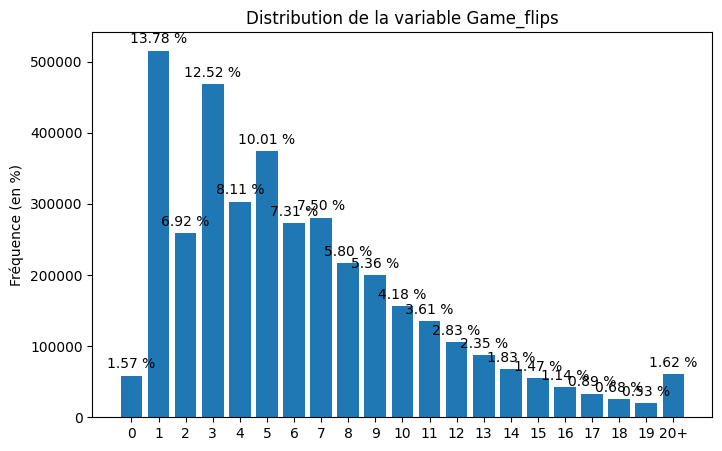

In [ ]:
total_games = lichess_df.count() # Nombre total de parties
game_flips = (
    lichess_df
    .withColumn(
        "Game_flips_binned",
        F.when(F.col("Game_flips") >= 20, "20+") # Classification de 0 à 20 et +
         .otherwise(F.col("Game_flips").cast("string"))
    )
    .groupBy("Game_flips_binned")
    .count()
    .withColumn(
        "proportion",
        F.col("count") / F.lit(total_games) * 100
    )
    .orderBy(
        F.when(F.col("Game_flips_binned") == "20+", 999)
         .otherwise(F.col("Game_flips_binned").cast("int"))
    )
)
game_flips_pd = game_flips.toPandas()

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(
    game_flips_pd["Game_flips_binned"],
    game_flips_pd["count"]
)

ax.bar_label(
    bars,
    labels=[f"{val:.2f} %" for val in game_flips_pd["proportion"]],
    padding=3
)

ax.set_ylabel("Fréquence (en %)")
ax.set_title("Distribution de la variable Game_flips")

plt.show();


En regardant la distribution du nombre de retournement au cours de toutes les parties, on peut observer que le nombre de retournements le plus fréquent est **1** avec **13.78%** suivi de près par **3** à **12.52%** et **5** avec **10.01%**.

On remarque également que la distribution est **fortement asymétrique**, avec une décroissance progressive lorsque le nombre de retournements augmente. Cela revient à dire que la majorité des parties connaissent très peu de retournements, ce qui correspond à un déroulement relativement stable, malgré des variations ponctuelles.

Pour la suite, il serait aussi très intéressant de voir si le fait que le nombre de retournement ne s'arrête qu'à un ne soit pas du à tout comportement différent d'une issue normale d'une partie, puis nous regarderons quelles sont les types de parties qui pourraient influencer le plus sur ces résultats.

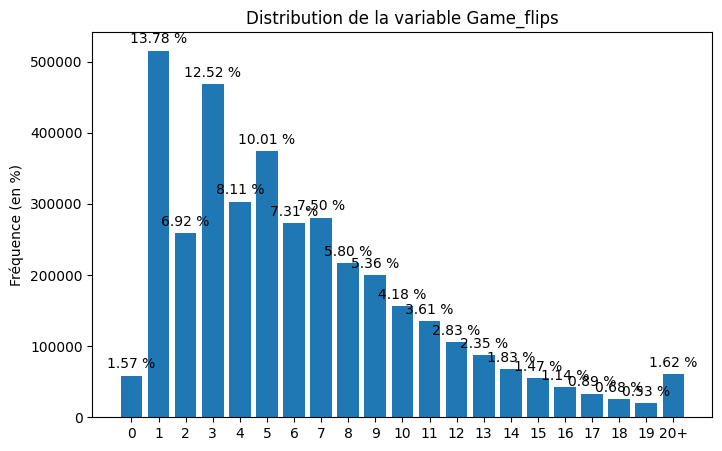

In [ ]:
total_games = lichess_df.count()
game_flips = (
    lichess_df
    .filter (
        # On ne tient pas en compte toutes les issues n'étant pas "Normales"
        (~(F.col("Termination").contains("Abandoned|Time forfeit|Rules infraction")))
    )
    .withColumn(
        "Game_flips_binned",
        F.when(F.col("Game_flips") >= 20, "20+")
         .otherwise(F.col("Game_flips").cast("string"))
    )
    .groupBy("Game_flips_binned")
    .count()
    .withColumn(
        "proportion",
        F.col("count") / F.lit(total_games) * 100
    )
    .orderBy(
        F.when(F.col("Game_flips_binned") == "20+", 999)
         .otherwise(F.col("Game_flips_binned").cast("int"))
    )
)
game_flips_pd = game_flips.toPandas()

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(
    game_flips_pd["Game_flips_binned"],
    game_flips_pd["count"]
)

ax.bar_label(
    bars,
    labels=[f"{val:.2f} %" for val in game_flips_pd["proportion"]],
    padding=3
)

ax.set_ylabel("Fréquence (en %)")
ax.set_title("Distribution de la variable Game_flips")

plt.show();

On peut observer que les deux graphiques représentant le nombre de flips dans une partie avec et sans les issues défavorables sont les mêmes. L'issue finale de la partie n'a donc **aucune influence significative** sur cette variable.

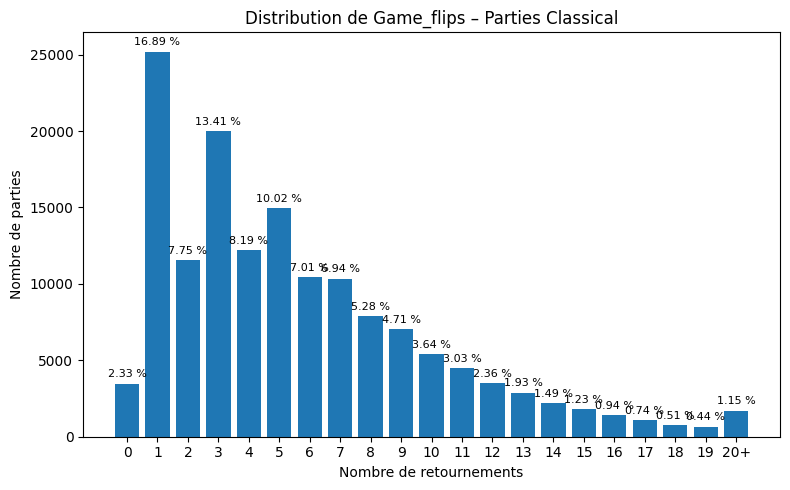

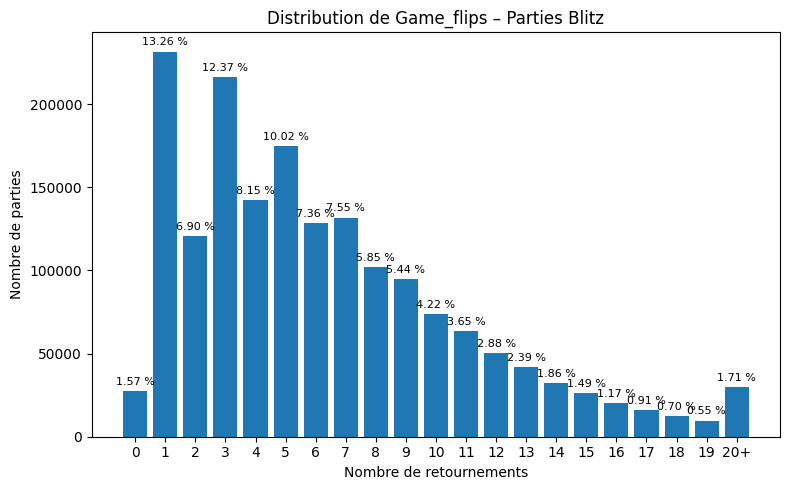

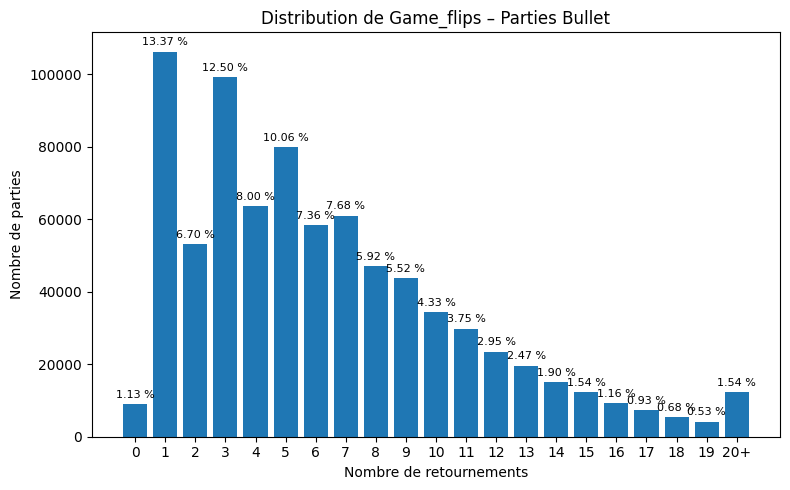

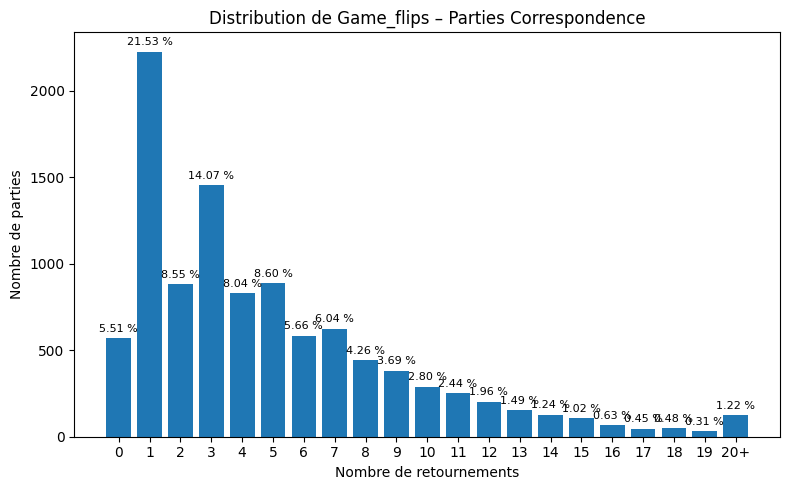

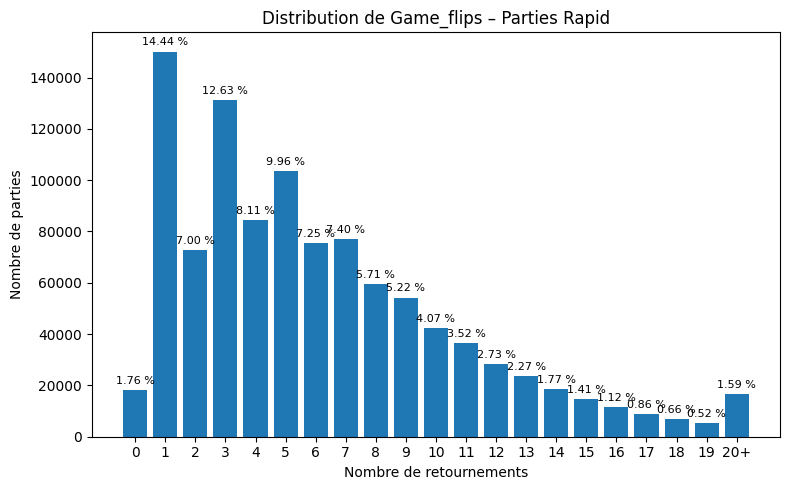

In [ ]:
types_parties = {
    "Classical": "classiques",
    "Blitz": "blitz",
    "Bullet": "bullet",
    "Correspondence": "correspondance",
    "Rapid": "rapides"
}

for type_p in types_parties :
  total_games = (
    lichess_df
    .filter(F.col("Event").contains(type_p))
    .count()
  )
  game_flips_by_type_of_game =  (
    lichess_df
    .filter(
        (F.col("Event").contains(type_p))
    )
    .withColumn(
        "Game_flips_binned",
        F.when(F.col("Game_flips") >= 20, "20+")
         .otherwise(F.col("Game_flips").cast("string"))
    )
    .groupBy("Game_flips_binned")
    .count()
    .withColumn(
        "proportion",
        F.col("count") / F.lit(total_games) * 100
    )
    .orderBy(
        F.when(F.col("Game_flips_binned") == "20+", 999)
         .otherwise(F.col("Game_flips_binned").cast("int"))
    )
  )
  game_flips_pd = game_flips_by_type_of_game.toPandas()

  fig, ax = plt.subplots(figsize=(8, 5))

  bars = ax.bar(
      game_flips_pd["Game_flips_binned"],
      game_flips_pd["count"]
  )

  ax.bar_label(
      bars,
      labels=[f"{val:.2f} %" for val in game_flips_pd["proportion"]],
      padding=3,
      fontsize=8
  )

  ax.set_xlabel("Nombre de retournements")
  ax.set_ylabel("Nombre de parties")
  ax.set_title(f"Distribution de Game_flips – Parties {type_p}")

  plt.tight_layout()
  plt.show()

Avec ces 5 graphiques, on observe à nouveau que le nombre de retournements le plus fréquent est 1, on observe encore une fois la distribution asymétrique avec la décroissance progressive quand le nombre de retournements augmente avec ce léger pics (plus ou moins grand en fonction du type de parties) lorsque le nombre de flips est supérieur à 20. Cependant on peut remarque que dans les parties *Blitz* et *Bullet*, l'écart entre le nombre de flips 1 et 3,n'est pas si grand que pour tous les autres types de parties. Mais comme on avait pu le voir lors de notre analyse exploratoire en début de notebook. Les parties les plus représentées dans le jeu de données sont les *Blitz*, les *Rapides* et les *Bullet*.

Maintenant, observons le niveau des joueurs, on aura plus d'informations sur le nombre de retournement selon leur catégorie de jeu.
Pour rappel, voici la distribution des catégories de joueurs :

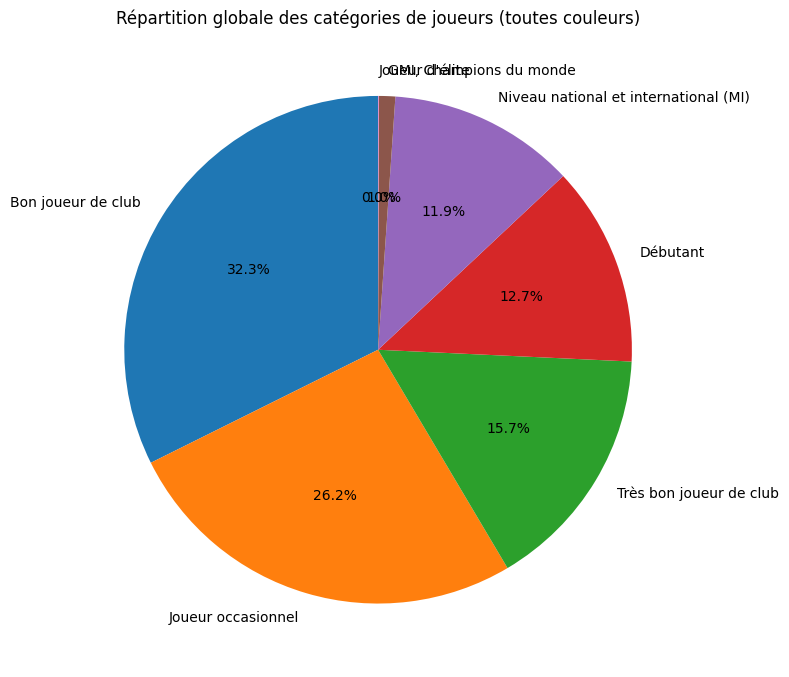

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
categories = ["Débutant", "Joueur occasionnel", "Bon joueur de club", "Très bon joueur de club",
              "Niveau national et international (MI)", "GMI, Champions du monde", "Joueur d'élite"]

# On met les catégories blancs et noirs dans une seule colonne
players_df = (
    lichess_df
    .select(
        F.col("Catégorie_blancs").alias("Categorie"),
        F.col("Game_flips") # Utile pour la suite
    )
    .union(
        lichess_df.select(
            F.col("Catégorie_noirs").alias("Categorie"),
            F.col("Game_flips")
        )
    )
)

# Comptage par catégorie
cat_counts = (
  players_df
  .groupBy("Categorie")
  .count()
)

# Total de joueurs (blancs + noirs)
total_players = cat_counts.agg(F.sum("count")).collect()[0][0]

# Calcul des proportions
cat_counts = (
  cat_counts
  .withColumn(
    "proportion",
    F.col("count") / F.lit(total_players) * 100
  )
  .orderBy(F.desc("count"))
)

cat_pd = cat_counts.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(
    cat_pd["proportion"],
    labels=cat_pd["Categorie"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Répartition globale des catégories de joueurs (toutes couleurs)")
plt.tight_layout()
plt.show()


On peut observer que la catégorie de joueurs la plus représentée dans le jeu de données est la catégorie Bon joueur de club, elle représente les joueurs dont l'ELO se trouve entre 1800 et 1999. La deuxième catégorie la plus représentée est Joueur occasionnel puis en troisième position les très bons joueurs de clubs.

En plus de l'hypothèse émise au départ disant que les parties impliquant des joueurs de niveau plus faibles avaient plus de chance d'avoir un nombre élevé de flips. Nous émettons donc l'hypothèse que les retournements de situations issues des trois premières catégories de joueurs sont donc celles qui représentent le plus la distribution vues avant. Nous pensons donc que les joueurs de niveau national et international ainsi que les Champions du monde et ceux au dessus auront sûrement une autre distribution pour ce nombre de retournements.

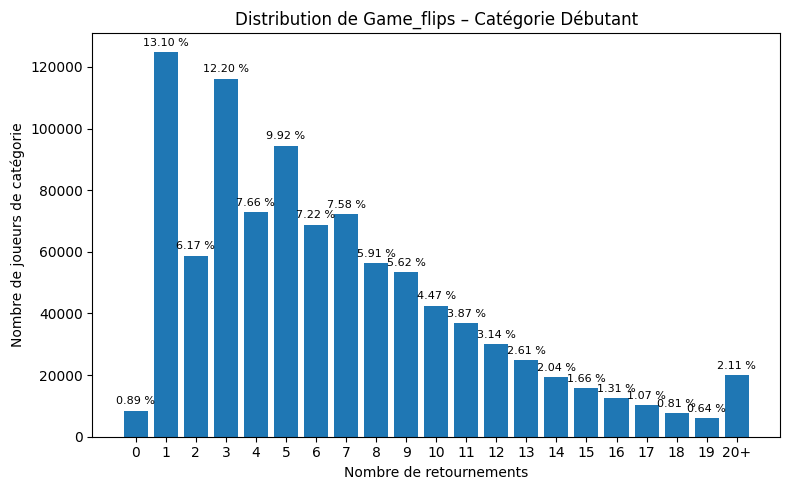

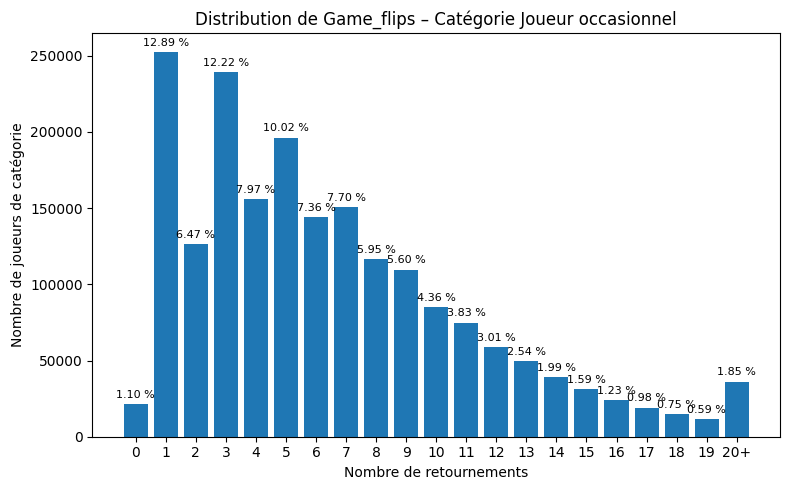

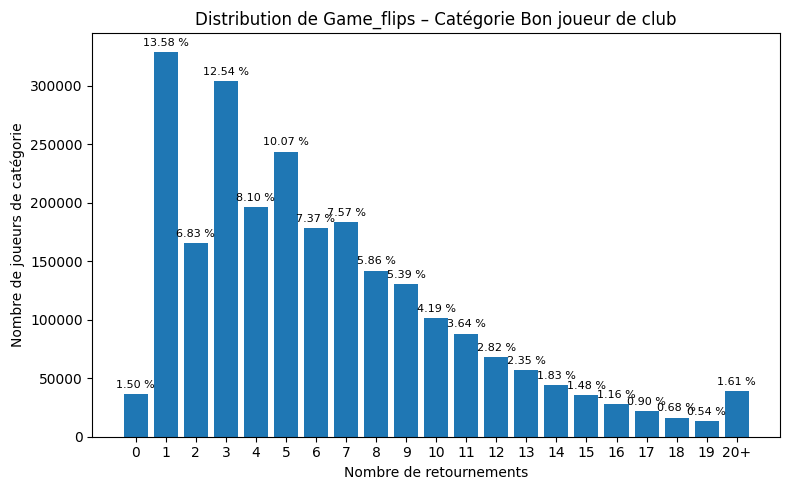

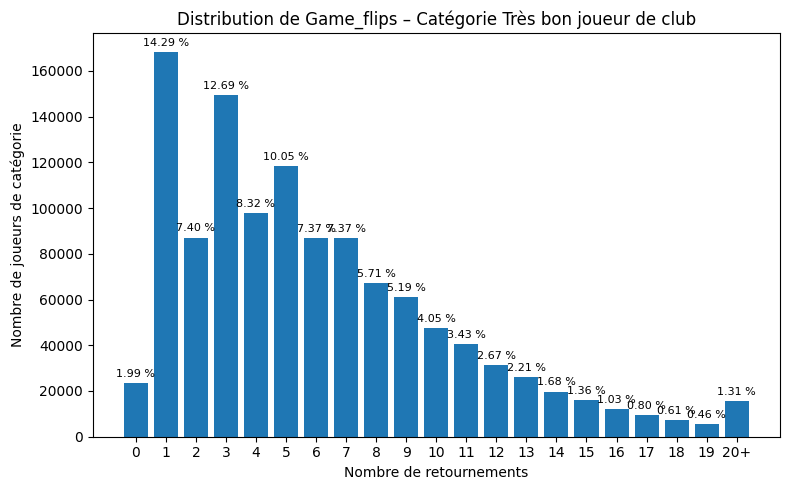

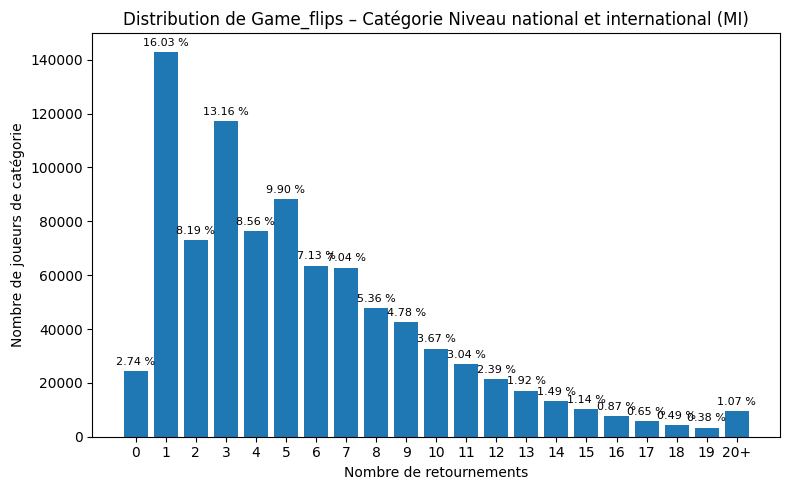

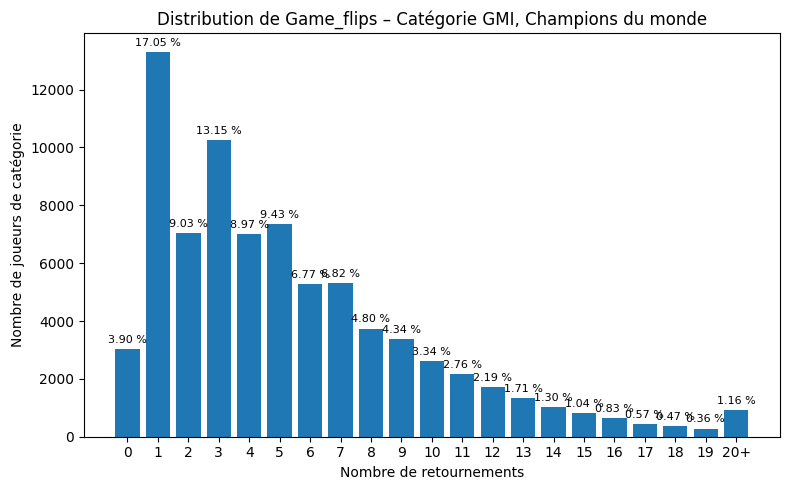

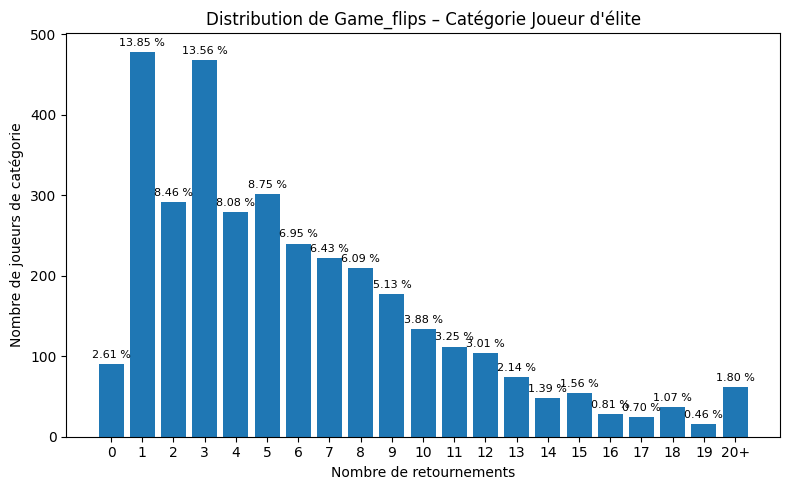

In [ ]:
categories = ["Débutant", "Joueur occasionnel", "Bon joueur de club", "Très bon joueur de club",
    "Niveau national et international (MI)", "GMI, Champions du monde", "Joueur d'élite"]


for cat in categories :
  df_cat = players_df.filter(F.col("Categorie") == cat)

  total_players = df_cat.count()

  game_flips_by_cat_of_player = (
      df_cat
      .withColumn(
          "Game_flips_binned",
          F.when(F.col("Game_flips") >= 20, "20+")
            .otherwise(F.col("Game_flips").cast("string"))
      )
      .groupBy("Game_flips_binned")
      .count()
      .withColumn(
          "proportion",
          F.col("count") / F.lit(total_players) * 100
      )
      .orderBy(
          F.when(F.col("Game_flips_binned") == "20+", 999)
            .otherwise(F.col("Game_flips_binned").cast("int"))
      )
  )
  game_flips_pd = game_flips_by_cat_of_player.toPandas()

  fig, ax = plt.subplots(figsize=(8, 5))

  bars = ax.bar(
      game_flips_pd["Game_flips_binned"],
      game_flips_pd["count"]
  )

  ax.bar_label(
      bars,
      labels=[f"{val:.2f} %" for val in game_flips_pd["proportion"]],
      padding=3,
      fontsize=8
  )

  ax.set_xlabel("Nombre de retournements")
  ax.set_ylabel("Nombre de joueurs de catégorie")
  ax.set_title(f"Distribution de Game_flips – Catégorie {cat}")

  plt.tight_layout()
  plt.show()

Contrairement à notre hypothèse de départ concernant le niveau des joueurs :  les joueurs de niveau débutant et occasionnels ne sont pas les seuls à présenter une distribution moins asymétrique. Les joueurs de niveau Elite (ELO supérieur à 2800) ont également une distribution moins asymétrique avec une décroissance plus lente du nombre de retournements, traduisant une proportion non négligeable de parties instables.

### Conclusion de la question 04
Les résultats montrent que la stabilité d'une partie dépend à la fois du niveau des joueurs et du type de partie, mais pas de manière strictement linéaire.
Si les joueurs débutants et occasionnels présentent effectivement davantage de retournements que les joueurs intermédiaires, les joueurs d'élite affichent également une instabilité.

Les parties rapides (*Blitz* et *Bullet*) tendent à être légèrement plus instables que les parties classiques, bien que ce résultat soit partiellement influencé par leur forte représentation dans le jeu de données.

## Conclusion
L'objectif de ce projet était d'analyser des parties d'échecs issues de la plateforme Lichess afin de comprendre quels facteurs influencent la qualité du jeu, le résultat des parties et si il était possible de prédire l'issue d'un match à l'aide des données fournies.
Pour cela, nous avons mené plusieurs analyses quantitatives structurées autour de cinq axes principaux :
 - l'analyse préalable pour voir comment est composé notre jeu de données
 - la qualité du jeu et le niveau des joueurs
 - les ouvertures et leurs probabilités de victoire
 - la préduction du résultat d'une partie
 - la stabilité des parties et retournements de situation
